In [2]:
install.packages('xts')
library(xts)
install.packages('markovchain')
library(markovchain)
install.packages('depmixS4')
library(depmixS4)
install.packages('PerformanceAnalytics')
library(PerformanceAnalytics)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘igraph’, ‘expm’, ‘RcppParallel’, ‘RcppArmadillo’


Loading required package: Matrix

Package:  markovchain
Version:  0.10.0
Date:     2024-11-14 00:00:02 UTC
BugReport: https://github.com/spedygiorgio/markovchain/issues



Attaching package: ‘markovchain’


The following object is masked from ‘package:zoo’:

    is.regular


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘truncnorm’, ‘Rsolnp’


Loading required package: nnet

Loading required package: MASS

Loading required package: Rsolnp

Loading required package: nlme

Installing package 

# Вариант 0

In [ ]:
var <- 0
data <- read.csv('GAZP.csv',header = T)
head(data)

,X.DATE.,X.CLOSE.
,<chr>,<dbl>
1,05/04/22,234.16
2,05/05/22,238.60
3,05/06/22,240.10
4,05/11/22,241.99
5,05/12/22,230.56
6,05/13/22,235.52


Для выдачи с календарными датами переводим данные в тип `time series’.

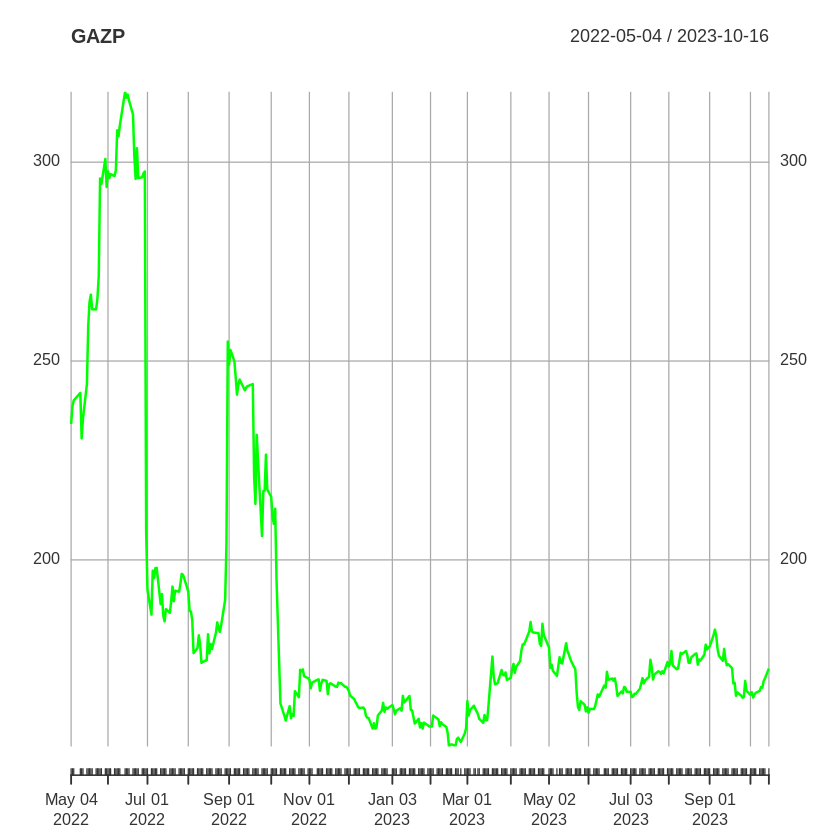

In [ ]:
Dates <-as.Date(data[,1],"%m/%d/%y")
histData <- data[,2]
sample.xts <- as.xts(histData, order.by = Dates)
plot(sample.xts,type = 'l',main = 'GAZP',col= 'green' )

Вычисляем ряд геометрических доходностей.

[1]  0.018961394  0.006286672  0.007871720 -0.047233357  0.021512838
[6]  0.036854620

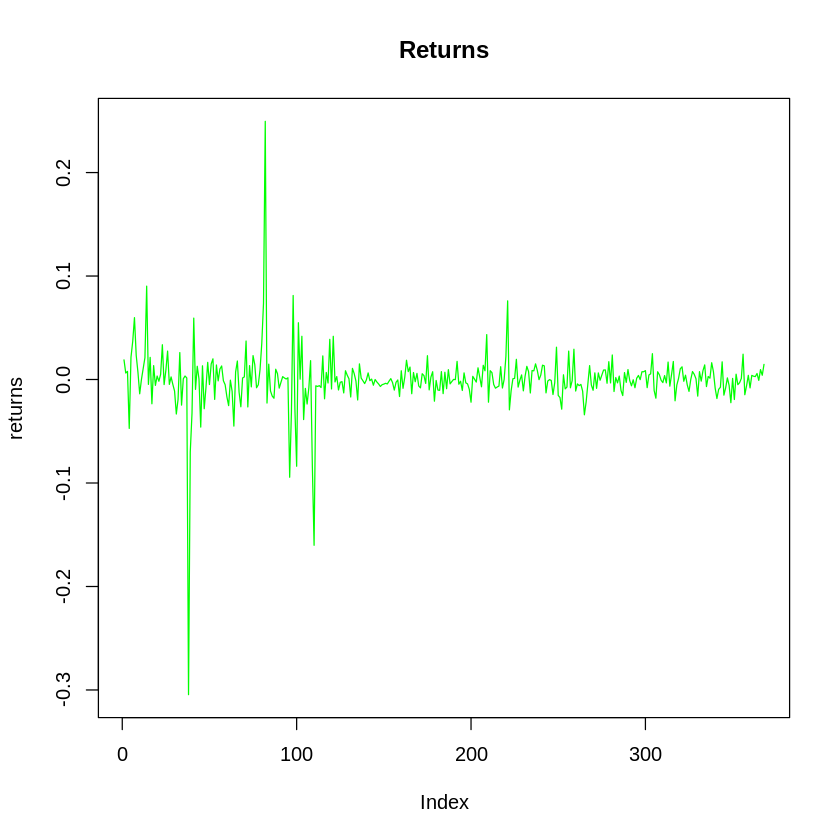

In [ ]:
returns = histData[2:length(histData)]/histData[-length(histData)] - 1
head(returns)
plot(returns,type = 'l',main = 'Returns',col = 'green')

Создаём HMM (Hidden Markov Model) объект для ряда доходностей и производим оценку HMM модели для трех состояний

In [ ]:
set.seed(100)

In [ ]:
hmm <- depmix(returns ~ 1, family = gaussian(), nstates = 3, data=data.frame(returns=returns))
hmmfit <- fit(hmm, verbose = FALSE)

converged at iteration 85 with logLik: 1009.094 


Получаем вероятности нахождения доходностей в некотором состоянии для каждой даты

Warning message in .local(object, ...):
“Argument 'type' not specified and will default to 'viterbi'. This default may change in future releases of depmixS4. Please see ?posterior for alternative options.”


,state,S1,S2,S3
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.0000000,0.00000000,0.000000e+00
2,1,0.9221888,0.01028830,6.752285e-02
3,1,0.8825452,0.01016884,1.072859e-01
4,1,0.7966997,0.20328708,1.317919e-05
5,1,0.9339069,0.05475564,1.133742e-02
6,1,0.9310261,0.06872779,2.461016e-04


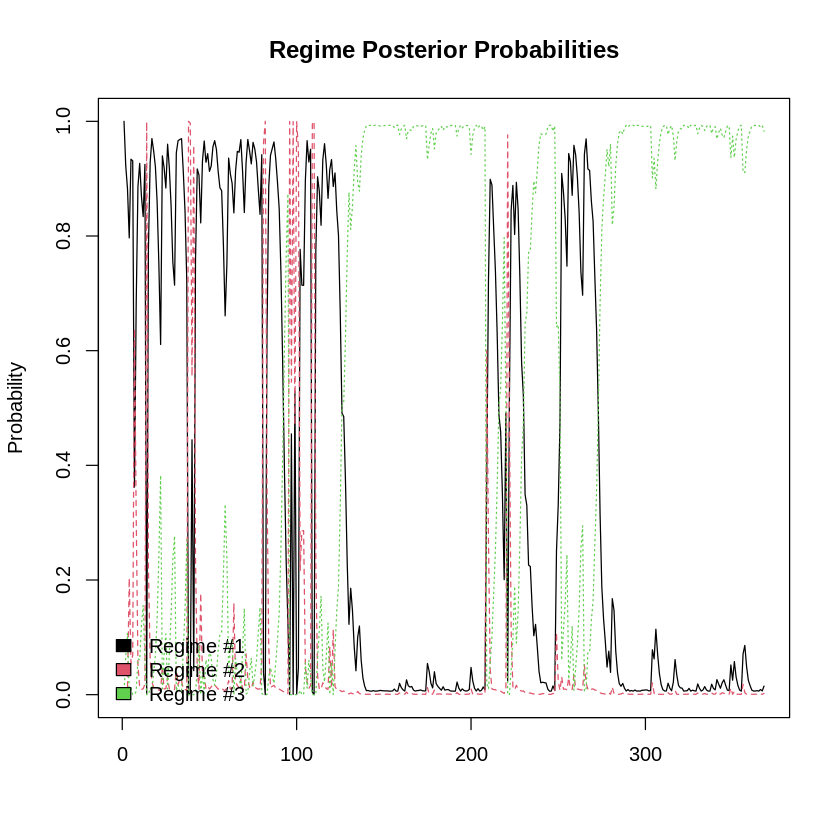

In [ ]:
post_probs <- posterior(hmmfit)
head(post_probs)
matplot(post_probs[,-1], type='l', main='Regime Posterior Probabilities', ylab='Probability')
legend(x='bottomleft', c('Regime #1','Regime #2', 'Regime #3'), fill=1:3, bty='n')

Получаем номера состояния для доходности в каждой календарной дате. Результат помещаем в переменную posterior_state.

In [ ]:
posterior_state <- hmmfit@posterior$state
head(posterior_state, 10)

[1] 1 1 1 1 1 1 1 1 1 1

In [ ]:
tail(posterior_state, 10)

[1] 3 3 3 3 3 3 3 3 3 3

По вектору состояний оцениваем матрицу переходных вероятностей за один день. Результат помещаем в переменную trmatr.

In [ ]:
hmm <- markovchainFit(data = posterior_state, method = "mle", name = "Alofi")
trmatr <- hmm$estimate@transitionMatrix
colnames(trmatr) <- c("1", "2", "3")
rownames(trmatr) <- c("1", "2", "3")
trmatr <- as.matrix(trmatr)
trmatr

,1,2,3
1,0.934306569,0.04379562,0.02189781
2,0.375000000,0.62500000,0.00000000
3,0.009345794,0.00000000,0.99065421


Определяем номер состояния в последний день наблюдений. Запоминаем его в переменной last_day_state.

In [ ]:
(last_day_state <- posterior_state[length(posterior_state)])

[1] 3

Задаём начальное распределение с нахождением в состоянии last_day_state.

In [ ]:
initialState <- rep(0,times = 3)
initialState[last_day_state] <- 1
initialState

[1] 0 0 1

Находим индексы в ряде доходностей, когда ряд находится в состоянии last_day_state. Также определяем ряд доходностей для этого состояния.

In [ ]:
ind_state <- which(posterior_state==last_day_state)
state_rates <- returns[ind_state]

In [ ]:
head(ind_state,10)

[1] 122 123 124 125 126 127 128 129 130 131

In [ ]:
tail(ind_state,10)

[1] 359 360 361 362 363 364 365 366 367 368

In [ ]:
head(state_rates,10)

[1] -0.0023204548  0.0028491685 -0.0100887111 -0.0026943127 -0.0020555588
 [6] -0.0129472693  0.0084664918  0.0041977060  0.0007065057 -0.0168853327

In [ ]:
tail(state_rates,10)

[1]  0.0040342004 -0.0080959520  0.0039903265  0.0031916175  0.0028212978
 [6]  0.0058062971 -0.0008331846  0.0095896122  0.0041297935  0.0146298472

Создаём объект типа “markovchain”

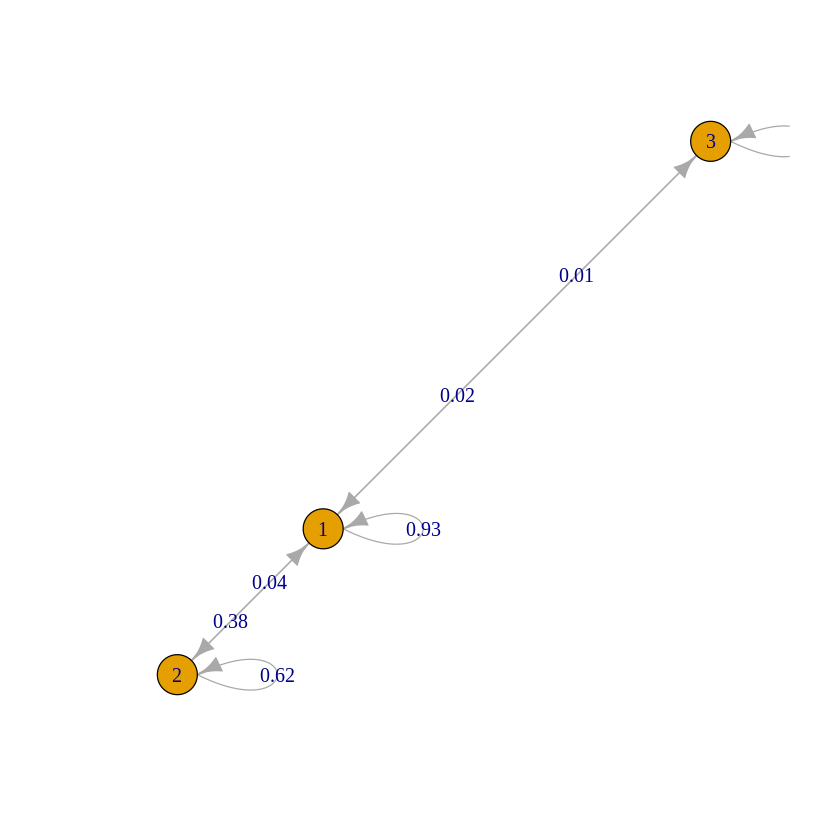

In [ ]:
mc <- new("markovchain",states=c("1", "2", "3"),byrow=TRUE,transitionMatrix=trmatr,name="GAZP")
plot(mc)

Находим вероятностное распределение состояния акции через 3 дня. Результат помещаем в переменную after3Days.

In [ ]:
(after3Days <- initialState * (mc * mc * mc))

1,2,3
0.02613577,0.001043711,0.9728205


Находим стационарное распределение состояния акции. Результат помещаем в переменную steady_states.

In [ ]:
(steady_states <-steadyStates(mc))

1,2,3
0.2890295,0.03375527,0.6772152


Вычисляем исторический 95% VaR (Value at Risk) для доходностей в последний день наблюдений при условии, что состояние в этот день равно last_day_state.

In [ ]:
(VaR_hist <- quantile(state_rates,0.05))

5% 
-0.01565927

In [ ]:
(VaR_hist <- VaR(state_rates,p=.95, method="historical"))

VaR,-0.01565927


Вычисляем исторический VaR для доходностей за весь период наблюдений вне зависимости от состояния.

In [ ]:
(VaR_all_returns <- VaR(returns,p=.95, method="historical"))

VaR,-0.02642833


Результат

In [ ]:
result <- list(
    variant = var, # номер варианта
    posterior_state = posterior_state,
    trmatr = trmatr, #матрица переходных вероятностей
    after3Days = after3Days,
    steady_states = steady_states,
    VaR_hist = VaR_hist,
    VaR_all_returns=VaR_all_returns
)

saveRDS(result, paste0('result_',var,'.rds'))

# Вариант 16


In [1]:
var <- 16
data <- read.csv('SBER.csv',header = T)
head(data)

,X.DATE.,X.CLOSE.
,<chr>,<dbl>
1,05/04/22,123.20
2,05/05/22,124.80
3,05/06/22,123.10
4,05/11/22,123.34
5,05/12/22,119.15
6,05/13/22,120.20


Для выдачи с календарными датами переводим данные в тип `time series’.

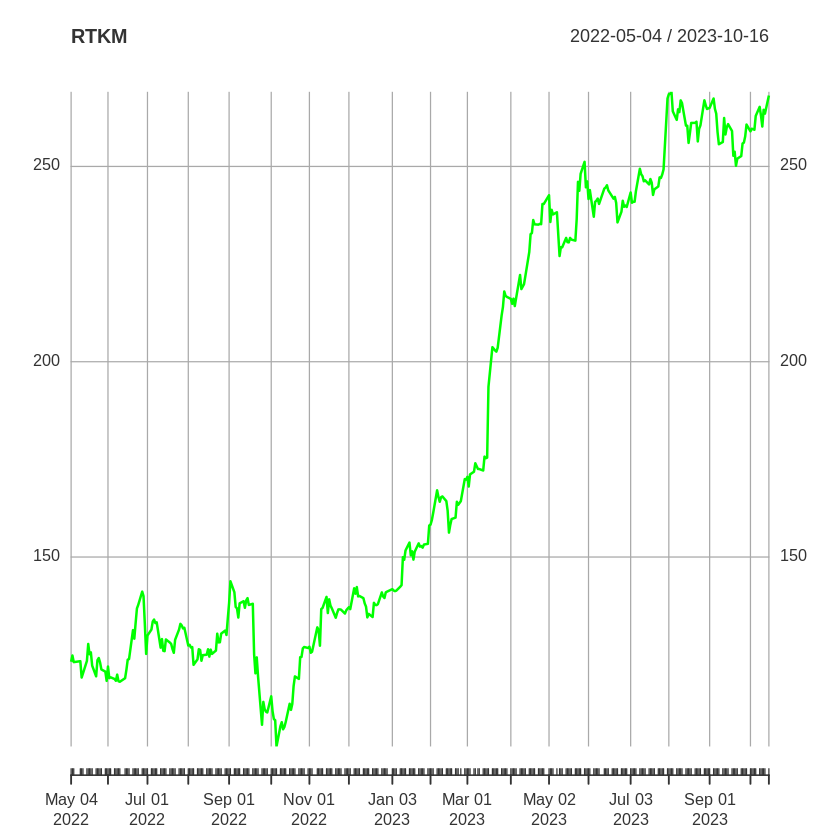

In [3]:
Dates <-as.Date(data[,1],"%m/%d/%y")
histData <- data[,2]
sample.xts <- as.xts(histData, order.by = Dates)
plot(sample.xts,type = 'l',main = 'RTKM',col= 'green' )

Вычисляем ряд геометрических доходностей.

[1]  0.012987013 -0.013621795  0.001949634 -0.033971137  0.008812421
[6]  0.026705491

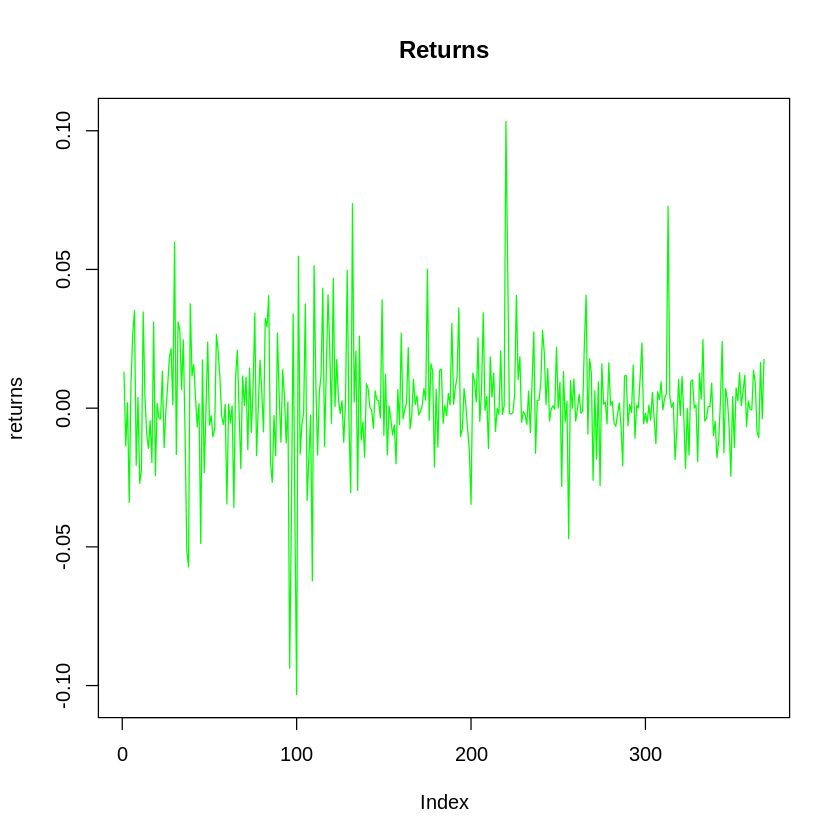

In [4]:
returns = histData[2:length(histData)]/histData[-length(histData)] - 1
head(returns)
plot(returns,type = 'l',main = 'Returns',col = 'green')

Создаём HMM (Hidden Markov Model) объект для ряда доходностей и производим оценку HMM модели для трех состояний

In [5]:
set.seed(100)

In [6]:
hmm <- depmix(returns ~ 1, family = gaussian(), nstates = 3, data=data.frame(returns=returns))
hmmfit <- fit(hmm, verbose = FALSE)

converged at iteration 96 with logLik: 974.6372 


Получаем вероятности нахождения доходностей в некотором состоянии для каждой даты

Warning message in .local(object, ...):
“Argument 'type' not specified and will default to 'viterbi'. This default may change in future releases of depmixS4. Please see ?posterior for alternative options.”


,state,S1,S2,S3
,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1.0000000,0.000000e+00,0.000000e+00
2,1,0.9961396,1.688122e-07,3.860271e-03
3,1,0.5085767,1.633161e-04,4.912600e-01
4,1,0.5884634,4.115366e-01,6.587059e-17
5,1,0.7925332,1.582082e-01,4.925865e-02
6,1,0.8875028,1.124972e-01,1.472696e-11


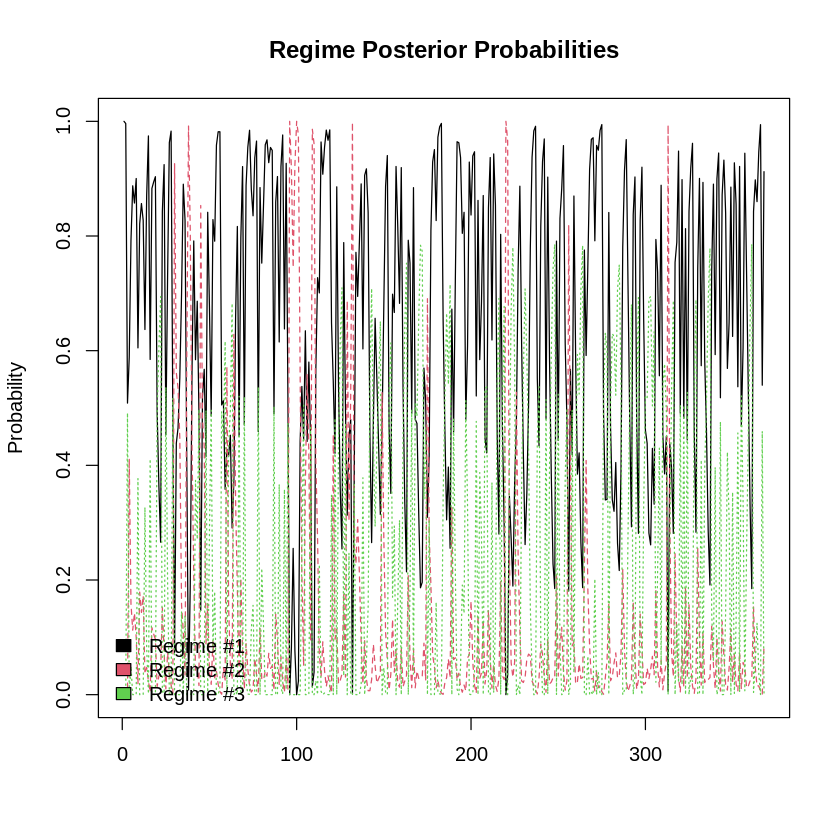

In [7]:
post_probs <- posterior(hmmfit)
head(post_probs)
matplot(post_probs[,-1], type='l', main='Regime Posterior Probabilities', ylab='Probability')
legend(x='bottomleft', c('Regime #1','Regime #2', 'Regime #3'), fill=1:3, bty='n')

Получаем номера состояния для доходности в каждой календарной дате. Результат помещаем в переменную posterior_state.

In [8]:
posterior_state <- hmmfit@posterior$state
head(posterior_state, 10)

[1] 1 1 1 1 1 1 1 1 1 1

In [9]:
tail(posterior_state, 10)

[1] 3 3 3 1 1 1 1 1 1 1

По вектору состояний оцениваем матрицу переходных вероятностей за один день. Результат помещаем в переменную trmatr.

In [10]:
hmm <- markovchainFit(data = posterior_state, method = "mle", name = "Alofi")
trmatr <- hmm$estimate@transitionMatrix
colnames(trmatr) <- c("1", "2", "3")
rownames(trmatr) <- c("1", "2", "3")
trmatr <- as.matrix(trmatr)
trmatr

,1,2,3
1,0.8927203,0.0000000,0.1072797
2,0.3333333,0.5714286,0.0952381
3,0.2470588,0.1058824,0.6470588


Определяем номер состояния в последний день наблюдений. Запоминаем его в переменной last_day_state.

In [11]:
(last_day_state <- posterior_state[length(posterior_state)])

[1] 1

Задаём начальное распределение с нахождением в состоянии last_day_state.

In [12]:
initialState <- rep(0,times = 3)
initialState[last_day_state] <- 1
initialState

[1] 1 0 0

Находим индексы в ряде доходностей, когда ряд находится в состоянии last_day_state. Также определяем ряд доходностей для этого состояния.

In [13]:
ind_state <- which(posterior_state==last_day_state)
state_rates <- returns[ind_state]

In [14]:
head(ind_state,10)

[1]  1  2  3  4  5  6  7  8  9 10

In [15]:
tail(ind_state,10)

[1] 356 357 358 362 363 364 365 366 367 368

In [16]:
head(state_rates,10)

[1]  0.012987013 -0.013621795  0.001949634 -0.033971137  0.008812421
 [6]  0.026705491  0.035167328 -0.020587084  0.003836317 -0.027070064

In [17]:
tail(state_rates,10)

[1]  0.006130418  0.011836846 -0.006673826  0.013686483  0.008823641
 [6] -0.008482564 -0.010608365  0.016486684 -0.003742911  0.017608440

Создаём объект типа “markovchain”

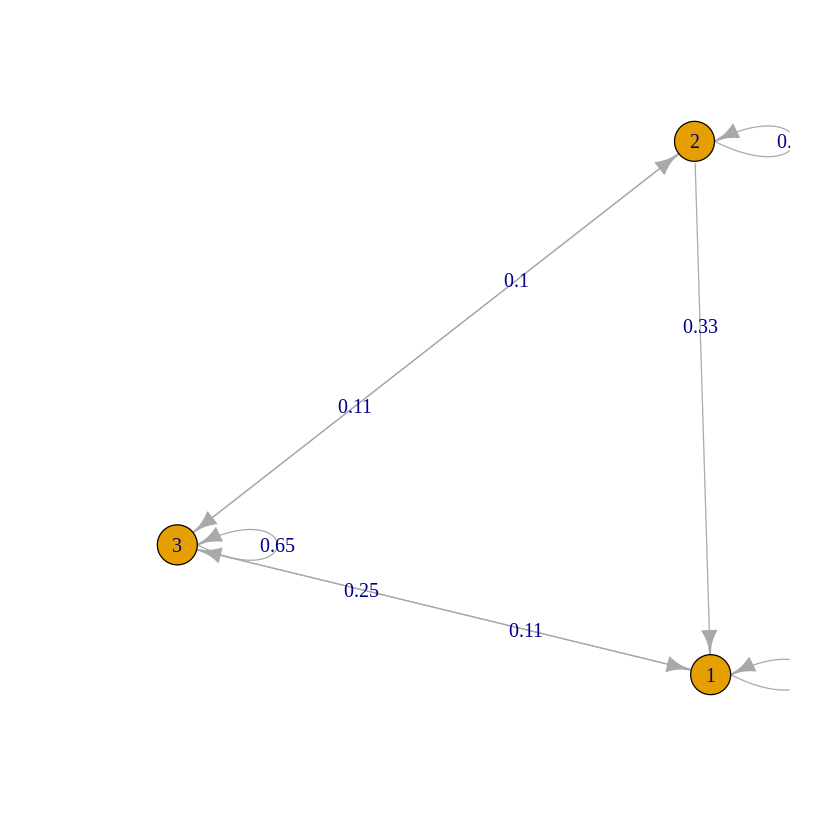

In [18]:
mc <- new("markovchain",states=c("1", "2", "3"),byrow=TRUE,transitionMatrix=trmatr,name="RTKM")
plot(mc)

Находим вероятностное распределение состояния акции через 3 дня. Результат помещаем в переменную after3Days.

In [19]:
(after3Days <- initialState * (mc * mc * mc))

1,2,3
0.7797113,0.02398126,0.1963074


Находим стационарное распределение состояния акции. Результат помещаем в переменную steady_states.

In [20]:
(steady_states <-steadyStates(mc))

1,2,3
0.7111717,0.05722071,0.2316076


Вычисляем исторический 95% VaR (Value at Risk) для доходностей в последний день наблюдений при условии, что состояние в этот день равно last_day_state.

In [21]:
(VaR_hist <- quantile(state_rates,0.05))

5% 
-0.02321414

In [22]:
(VaR_hist <- VaR(state_rates,p=.95, method="historical"))

VaR,-0.02321414


Вычисляем исторический VaR для доходностей за весь период наблюдений вне зависимости от состояния.

In [23]:
(VaR_all_returns <- VaR(returns,p=.95, method="historical"))

VaR,-0.0269537


Результат

In [24]:
result <- list(
    variant = var, # номер варианта
    posterior_state = posterior_state,
    trmatr = trmatr, #матрица переходных вероятностей
    after3Days = after3Days,
    steady_states = steady_states,
    VaR_hist = VaR_hist,
    VaR_all_returns=VaR_all_returns
)

saveRDS(result, paste0('result_',var,'.rds'))